In [1]:
%load_ext autoreload
%autoreload 2
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import ggplot, geom_point, geom_violin, geom_boxplot, geom_jitter
from plotnine import aes, stat_smooth, facet_wrap, scale_fill_manual, theme_bw, element_blank
from plotnine import guides, theme, labs, element_text, guide_legend
from statannot import add_stat_annotation
from scipy.stats import ranksums

import rpy2.rinterface
%load_ext rpy2.ipython

In [2]:
# File paths
CCLE_MRN_PROT_PATH = "../analysis_files/CCLE_MRN_complex_proteomics.tsv"
CCLE_MRN_TPM_PATH = "../analysis_files/CCLE_MRN_complex_tpm.tsv"

msi_colname = 'CCLE (NGS) MSI status Microsatellite Instability'

In [4]:
# Load data
mrn_ccle_prot_df = pd.read_csv(CCLE_MRN_PROT_PATH, sep='\t', index_col=0)
mrn_ccle_tpm_df = pd.read_csv(CCLE_MRN_TPM_PATH, sep='\t', index_col=0)

mrn_ccle_prot_df = mrn_ccle_prot_df[mrn_ccle_prot_df['Primary Disease'].isin(
    ['Colorectal Adenocarcinoma', 'Endometrial Carcinoma'])]
mrn_ccle_tpm_df = mrn_ccle_tpm_df[mrn_ccle_tpm_df['Primary Disease'].isin(
    ['Colorectal Adenocarcinoma', 'Endometrial Carcinoma'])]
mrn_ccle_tpm_df = mrn_ccle_tpm_df[mrn_ccle_tpm_df[msi_colname].isin(['MSI', 'MSS'])]

mrn_ccle_tpm_df['cohort_shape'] = mrn_ccle_tpm_df['Primary Disease'].map(
    {"Colorectal Adenocarcinoma":"triangle", 'Endometrial Carcinoma':'circle'})

In [5]:
%%R
library(ggplot2)
library(ggpubr)

## 1. CCLE Depmap MRN analysis (Figure S3D)

In [6]:
%R -i mrn_ccle_prot_df -i mrn_ccle_tpm_df -i CCLE_MRN_PROT_PATH -i CCLE_MRN_TPM_PATH

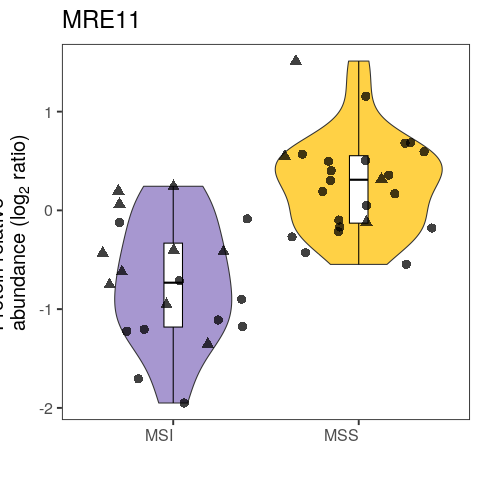

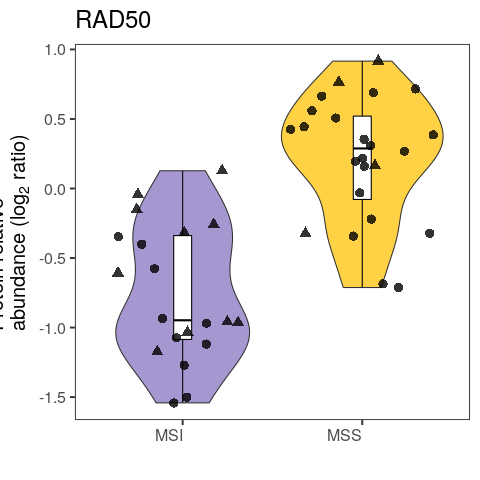

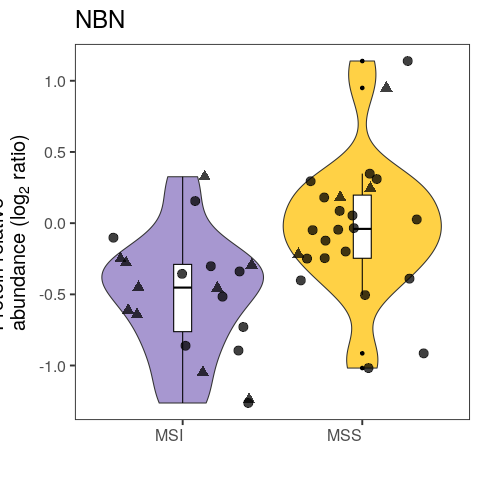

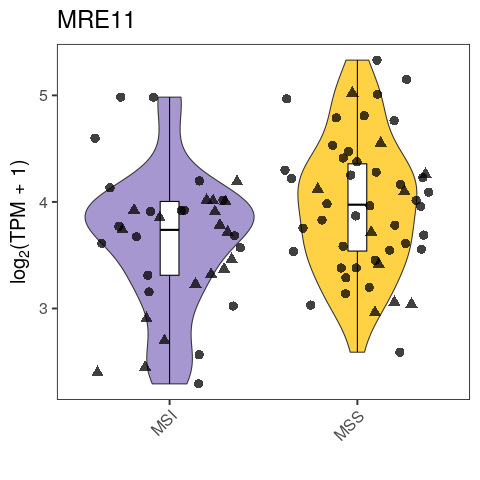

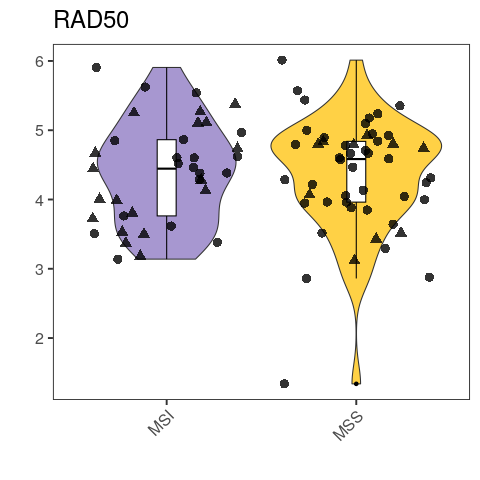

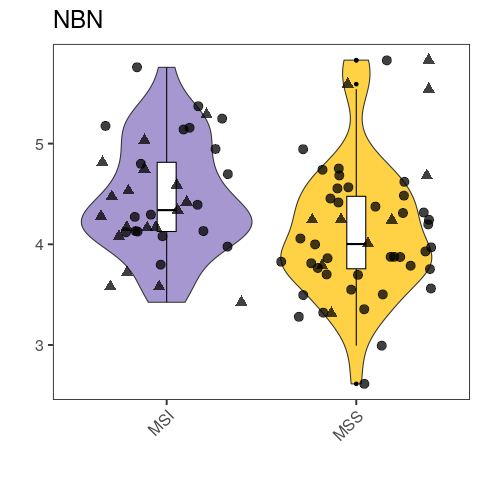

In [8]:
%%R 
# Load data
mrn_ccle_tpm_df = read.table(CCLE_MRN_TPM_PATH,
                             sep='\t', header=TRUE, row.names=1)
mrn_ccle_prot_df = read.table(CCLE_MRN_PROT_PATH,
                             sep='\t', header=TRUE, row.names=1)

# Remove unassigned MSI status
mrn_ccle_tpm_df <- mrn_ccle_tpm_df[which(mrn_ccle_tpm_df$CCLE..NGS..MSI.status.Microsatellite.Instability %in% c("MSI", "MSS")), ]

mrn_ccle_tpm_df <- mrn_ccle_tpm_df[which(mrn_ccle_tpm_df$Primary.Disease %in% c("Colorectal Adenocarcinoma", "Endometrial Carcinoma")),]
mrn_ccle_prot_df <- mrn_ccle_prot_df[which(mrn_ccle_prot_df$Primary.Disease %in% c("Colorectal Adenocarcinoma", "Endometrial Carcinoma")),]

mrn_ccle_prot_df$cohort_shape = ifelse(mrn_ccle_prot_df$Primary.Disease == 'Colorectal Adenocarcinoma', "triangle", "circle")
mrn_ccle_tpm_df$cohort_shape = ifelse(mrn_ccle_tpm_df$Primary.Disease == 'Colorectal Adenocarcinoma', "triangle", "circle")
mrn_ccle_prot_df$cohort = ifelse(mrn_ccle_prot_df$Primary.Disease == 'Colorectal Adenocarcinoma', 'COAD', 'UCEC')
mrn_ccle_tpm_df$cohort = ifelse(mrn_ccle_tpm_df$Primary.Disease == 'Colorectal Adenocarcinoma', 'COAD', 'UCEC')

mrn_ccle_tpm_df$cohort = factor(mrn_ccle_tpm_df$cohort, levels=c("COAD", "UCEC"))
mrn_ccle_prot_df$cohort = factor(mrn_ccle_prot_df$cohort, levels=c("COAD", "UCEC"))
mrn_ccle_tpm_df$cohort_shape = factor(mrn_ccle_tpm_df$cohort_shape, levels=c("triangle", "circle"))
mrn_ccle_prot_df$cohort_shape = factor(mrn_ccle_prot_df$cohort_shape, levels=c("triangle", "circle"))

msi_colname = 'CCLE..NGS..MSI.status.Microsatellite.Instability'
mre11_prot_colname = 'MRE11..P49959..Relative.Protein.Expression.Proteomics'
rad50_prot_colname = 'RAD50..Q92878.2..Relative.Protein.Expression.Proteomics'
nbn_prot_colname = 'NBN..O60934..Relative.Protein.Expression.Proteomics'
mre11_tpm_colname = 'MRE11.log2.TPM.1..Expression.Public.22Q4'
rad50_tpm_colname = 'RAD50.log2.TPM.1..Expression.Public.22Q4'
nbn_tpm_colname = 'NBN.log2.TPM.1..Expression.Public.22Q4'

yaxis_lab <- expression("\n\nProtein relative\nabundance (log"[2]*" ratio)")
MRE11_violin <- ggplot(mrn_ccle_prot_df, aes_string(x = msi_colname, y = mre11_prot_colname))+
  geom_violin(aes_string(fill = msi_colname), varwidth = T, alpha = 0.75) +
  geom_boxplot(width=0.1,colour="black") +
  geom_jitter(alpha = 0.75, aes(shape=factor(cohort_shape)), size=4) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"))+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
  labs(title="MRE11", y= yaxis_lab, x= "")+
  theme(axis.text.x=element_text(hjust=1),
        legend.position = "none")
NBN_violin <- ggplot(mrn_ccle_prot_df, aes_string(x = msi_colname, y = nbn_prot_colname))+
  geom_violin(aes_string(fill = msi_colname), varwidth = T, alpha = 0.75) +
  geom_boxplot(width=0.1,colour="black") +
  geom_jitter(alpha = 0.75, aes(shape=factor(cohort_shape)), size=4) +
  scale_shape_manual(name='Cancer type', values=c('circle', 'triangle'), labels=c('UCEC', 'COAD')) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"), guide="none")+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
  labs(title="NBN", y= yaxis_lab, x= "")+
  theme(axis.text.x=element_text(hjust=1), legend.position="none")
RAD50_violin <- ggplot(mrn_ccle_prot_df, aes_string(x = msi_colname, y = rad50_prot_colname))+
  geom_violin(aes_string(fill = msi_colname), varwidth = T, alpha = 0.75)+
  geom_boxplot(width=0.1,colour="black") +
  geom_jitter(alpha = 0.8, aes(shape=factor(cohort_shape)), size=4) +
  scale_colour_manual(name="colour", values=c("black", "red")) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"))+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
  labs(title="RAD50", y= yaxis_lab, x= "")+
  theme(axis.text.x=element_text(hjust=1),
        legend.position = "none")
ggsave("Figure_S3D_MRE11_ccle_prot.pdf", MRE11_violin, path="figures/", 
       height=4, width=4, dpi=64)
ggsave("Figure_S3D_RAD50_ccle_prot.pdf", RAD50_violin, path="figures/", 
       height=4, width=4, dpi=64)
ggsave("Figure_S3D_NBN_ccle_prot.pdf", NBN_violin, path="figures/", 
       height=4, width=4, dpi=64)
print(MRE11_violin)
print(RAD50_violin)
print(NBN_violin)

# RNA
MRE11_violin <- ggplot(mrn_ccle_tpm_df, aes_string(x = msi_colname, y = mre11_tpm_colname))+
  geom_violin(aes_string(fill = msi_colname), varwidth = T, alpha = 0.75) +
  geom_boxplot(width=0.1,colour="black") +
  geom_jitter(alpha = 0.75, aes(shape=factor(cohort_shape)), size=4) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"))+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
  labs(title="MRE11", y= expression("log"[2]*"(TPM + 1)"), x= "")+
  theme(axis.text.x=element_text(angle=45, hjust=1),
        legend.position = "none")
NBN_violin <- ggplot(mrn_ccle_tpm_df, aes_string(x = msi_colname, y = nbn_tpm_colname))+
  geom_violin(aes_string(fill = msi_colname), varwidth = T, alpha = 0.75) +
  geom_boxplot(width=0.1,colour="black") +
  geom_jitter(alpha = 0.75, aes(shape=factor(cohort_shape)), size=4) +
  scale_shape_manual(name='Cancer type', values=c('circle', 'triangle'), labels=c('UCEC', 'COAD')) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"), guide="none")+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
  labs(title="NBN", y= "", x= "")+
  theme(axis.text.x=element_text(angle=45, hjust=1), legend.position="none")
RAD50_violin <- ggplot(mrn_ccle_tpm_df, aes_string(x = msi_colname, y = rad50_tpm_colname))+
  geom_violin(aes_string(fill = msi_colname), varwidth = T, alpha = 0.75)+
  geom_boxplot(width=0.1,colour="black") +
  geom_jitter(alpha = 0.8, aes(shape=factor(cohort_shape)), size=4) +
  scale_colour_manual(name="colour", values=c("black", "red")) +
  scale_fill_manual(values=c("#8A74C0","#FFC107"))+
  theme_bw(base_size = 20)+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
  labs(title="RAD50", y= "", x= "")+
  theme(axis.text.x=element_text(angle=45, hjust=1),
        legend.position = "none")
ggsave("Figure_S3D_MRE11_ccle_rna.pdf", MRE11_violin, path="figures/", dpi=64, height=6, width=6)
ggsave("Figure_S3D_RAD50_ccle_rna.pdf", RAD50_violin, path="figures/", height=6, width=6, dpi=64)
ggsave("Figure_S3D_NBN_ccle_rna.pdf", NBN_violin, path="figures/", height=6, width=6, dpi=64)

print(MRE11_violin)
print(RAD50_violin)
print(NBN_violin)


In [25]:
# Statistical tests
# MRE11
mre11_protname = 'MRE11 (P49959) Relative Protein Expression Proteomics'
stat, p = ranksums(mrn_ccle_prot_df[mrn_ccle_prot_df[msi_colname]=='MSI'][mre11_protname],
                   mrn_ccle_prot_df[mrn_ccle_prot_df[msi_colname]=='MSS'][mre11_protname])
print(f"MRE11:\n\tProtein: {p:.1e}")
mre11_rnaname = "MRE11 log2(TPM+1) Expression Public 22Q4"
stat, p = ranksums(mrn_ccle_tpm_df[mrn_ccle_tpm_df[msi_colname]=='MSI'][mre11_rnaname],
                   mrn_ccle_tpm_df[mrn_ccle_tpm_df[msi_colname]=='MSS'][mre11_rnaname])
print(f"\tRNA: {p:.1e}")

# RAD50
rad50_protname = 'RAD50 (Q92878-2) Relative Protein Expression Proteomics'
stat, p = ranksums(mrn_ccle_prot_df[mrn_ccle_prot_df[msi_colname]=='MSI'][rad50_protname],
                   mrn_ccle_prot_df[mrn_ccle_prot_df[msi_colname]=='MSS'][rad50_protname])
print(f"RAD50:\n\tProtein: {p:.1e}")
rad50_rnaname = "RAD50 log2(TPM+1) Expression Public 22Q4"
stat, p = ranksums(mrn_ccle_tpm_df[mrn_ccle_tpm_df[msi_colname]=='MSI'][rad50_rnaname],
                   mrn_ccle_tpm_df[mrn_ccle_tpm_df[msi_colname]=='MSS'][rad50_rnaname])
print(f"\tRNA: {p:.1e}")

# NBN
nbn_protname = 'NBN (O60934) Relative Protein Expression Proteomics'
stat, p = ranksums(mrn_ccle_prot_df[mrn_ccle_prot_df[msi_colname]=='MSI'][nbn_protname],
                   mrn_ccle_prot_df[mrn_ccle_prot_df[msi_colname]=='MSS'][nbn_protname])
print(f"NBN:\n\tProtein: {p:.1e}")
nbn_rnaname = "NBN log2(TPM+1) Expression Public 22Q4"
stat, p = ranksums(mrn_ccle_tpm_df[mrn_ccle_tpm_df[msi_colname]=='MSI'][nbn_rnaname],
                   mrn_ccle_tpm_df[mrn_ccle_tpm_df[msi_colname]=='MSS'][nbn_rnaname])
print(f"\tRNA: {p:.1e}")

MRE11:
	Protein: 7.5e-06
	RNA: 2.7e-02
RAD50:
	Protein: 1.7e-06
	RNA: 8.9e-01
NBN:
	Protein: 6.3e-04
	RNA: 8.8e-03


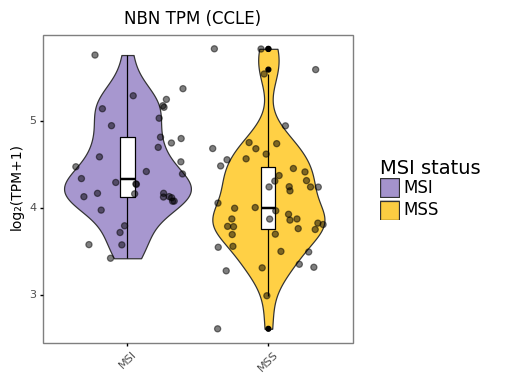

In [6]:
tpm_colname = 'NBN log2(TPM+1) Expression Public 22Q4'
p = (ggplot(mrn_ccle_tpm_df, aes(x = msi_colname, y=tpm_colname)) 
     + geom_violin(aes(fill = msi_colname), alpha = 0.75) 
     + geom_boxplot(width=0.1,colour="black") 
     + geom_jitter(alpha = 0.5, size=2) 
     + scale_fill_manual(values=["#8A74C0","#FFC107"], guide="none")
     + theme_bw(base_size = 10) 
     + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank())
     + labs(title="NBN TPM (CCLE)", y= u"log\N{SUBSCRIPT TWO}(TPM+1)", x= "") 
     + theme(axis_text_x=element_text(angle=45), figure_size=(4,4)) 
     + guides(fill=guide_legend(title="MSI status")) 
     + theme(legend_text=element_text(size=12), legend_title=element_text(size=14))
    )
fig = p.draw()
axs = fig.get_axes()
